In this exercise we will be trying to model the likelihood of students being accepted into a certain graduate school degree course. 

The data is taken from here: https://www.kaggle.com/datasets/mukeshmanral/graduates-admission-prediction?resource=download

We are essentially given several quantitative metrics to describe the performance of students and between them we need to create a model that predicts the likelihood of a student being made an offer. 

At surface value this seems like a linear regression problem. We should inspect the distributions as it may be that some of them require normalizing to improve the accuracy of their contributions to the model. 

In [1]:
#Load modules 
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt 
import plotly.graph_objects as go  
import plotly.express as px 

In [2]:
#open the dataset we will be working on
df = pd.read_csv("admission_data.csv")
df

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...
495,332,108,5,4.5,4.0,9.02,1,0.87
496,337,117,5,5.0,5.0,9.87,1,0.96
497,330,120,5,4.5,5.0,9.56,1,0.93
498,312,103,4,4.0,5.0,8.43,0,0.73


In [3]:
#first small look at the nature of the data 
df.describe()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


First thoughts of this dataset are:

GRE and TOEFL scores don't seem to contain that much variety across their full scale?

University Ranking varies a lot as do many of the other subjective criteria. 

The criteria based on a score out of 5 have a large variance but this might be an artifact of the 20% binning and the way that people use these scales to measure things may produce very different results to absolute scores out of 100 for example. 

The "Research" category has a very wide variance, which is representative of the nature of recent grads who often have patchy research experience as well as the binary nature of the category. 

In general the chance of admission is fairly high with a mean of 72% acceptance. This is a strange dataset as it has a 'chance of acceptance' rather than a binary 'were they accepted' parameter. I would say this is atypical for this kind of dataset and not representative of real world data. 


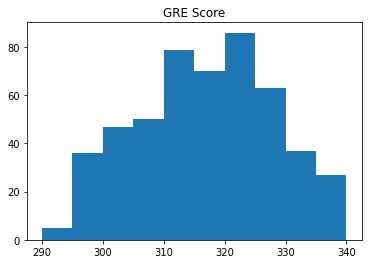

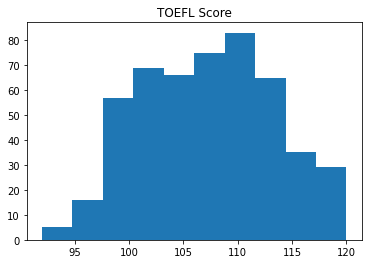

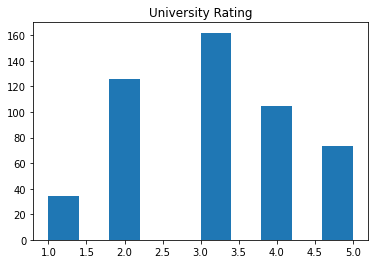

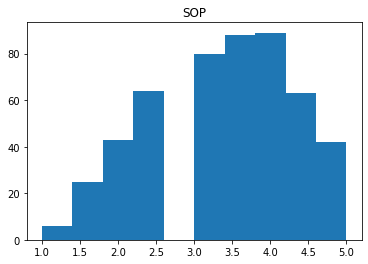

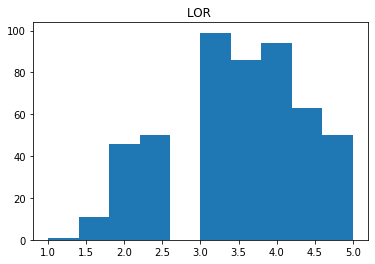

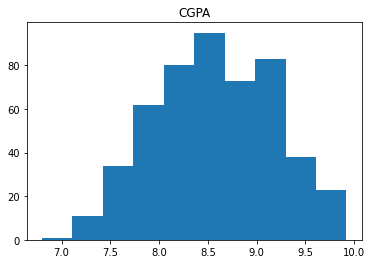

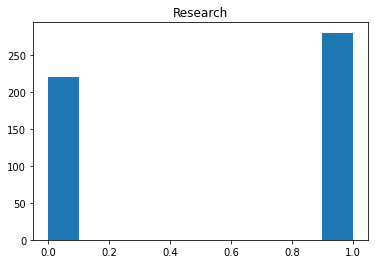

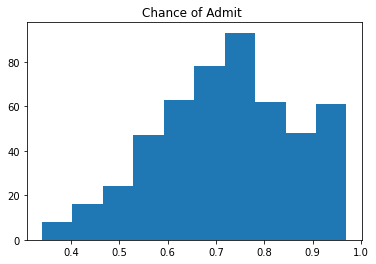

In [4]:
#First step is to check if the parameters we are looking at are normally distributed
#In order to do this we will loop through columns and create histograms

for i in df.columns:
    plt.hist(df[i])
    plt.title(i)
    plt.show()

In [5]:
#Looks like most are fairly normally distributed apart from SOP, LOR and Research 
#We may decide later we want to do something about these to see if we can improve the model at all

Now let's have a first pass at clearing up the dataset

In [6]:
df = df.dropna()
df

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...
495,332,108,5,4.5,4.0,9.02,1,0.87
496,337,117,5,5.0,5.0,9.87,1,0.96
497,330,120,5,4.5,5.0,9.56,1,0.93
498,312,103,4,4.0,5.0,8.43,0,0.73


Seems like the dataset was complete so now let's look into our first analysis steps. 

Might be nice to run a really quick correlation check to see how the variables interact with each other before we proceed. 

<AxesSubplot:>

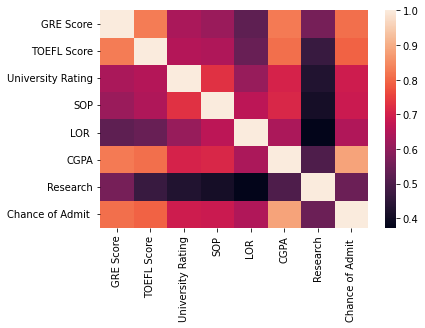

In [7]:
df.corr()
sns.heatmap(df.corr())

This is difficult to interpret because the scale the metrics are used on influences the correlation more than actual relationships in the data. We could get more from it if every variable was normalised before we began. 

In [8]:
df.columns

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA',
       'Research', 'Chance of Admit '],
      dtype='object')

N.b. some of these column names have spaced which need to be included. Could strip the whitespace if you wanted to as well. 


In [9]:
#Create our variables
X = df[["GRE Score","TOEFL Score","University Rating","SOP","CGPA","Research", "LOR "]]
Y = df[["Chance of Admit "]]
X


,GRE Score,TOEFL Score,University Rating,SOP,CGPA,Research,LOR
0,337,118,4,4.5,9.65,1,4.5
1,324,107,4,4.0,8.87,1,4.5
2,316,104,3,3.0,8.00,1,3.5
3,322,110,3,3.5,8.67,1,2.5
4,314,103,2,2.0,8.21,0,3.0
...,...,...,...,...,...,...,...
495,332,108,5,4.5,9.02,1,4.0
496,337,117,5,5.0,9.87,1,5.0
497,330,120,5,4.5,9.56,1,5.0
498,312,103,4,4.0,8.43,0,5.0


Now that we have this we can start building our models using scikitlearn. 

In [10]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3)

In [12]:
X_train = X_train.to_numpy()

In [13]:
model.fit(X_train, Y_train)

/var/folders/r1/fnrs32ds6yq9ghyvft_tz_800000gn/T/ipykernel_18088/4132381083.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, Y_train)


RandomForestRegressor()

This has now generated our model using the Random Forest Regressor algorithm. This was generated using 70% of the data to train, but I guess we could also go up to 80% if we wanted. SciKitLearn has an inbuilt 
'accuracy prediction' which basically just monitors the power of the regression. We can check that now. 

In [14]:
acc = model.score(X_test, Y_test)
acc

/Users/bphillips/opt/anaconda3/envs/Experimental/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


0.7852486977688239

So this model is operating at a claimed accuracy of 74%. This can for sure by improved with many approaches. The first one would be getting lazypredict to work properly to decide which algorithm would work best on this dataset. The second would be using some degree of cross validation. The third would be normalising the inputs which seemed not to have a normal distribution. 

Before we get into that we can make a bunch of predicitons from our reserved 30% of the dataset and plot them graphically against the actual admissions success to get an idea of how well our model is working already: 

In [15]:
predictions = model.predict(X_test)

/Users/bphillips/opt/anaconda3/envs/Experimental/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


/Users/bphillips/opt/anaconda3/envs/Experimental/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

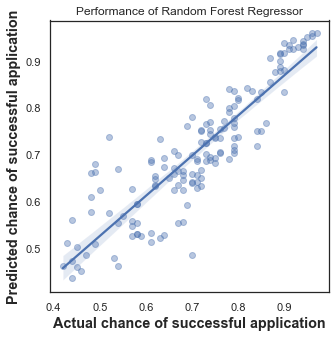

In [16]:
sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Y_test, predictions, scatter_kws={'alpha':0.4})
ax.set_xlabel('Actual chance of successful application', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted chance of successful application', fontsize='large', fontweight='bold')
#ax.set_xlim(-15, 20)
#ax.set_ylim(-10, 5)
ax.set(title='Performance of Random Forest Regressor')
ax.figure.set_size_inches(5, 5)
plt.show
#plt.savefig("RandomForest_outliers_inlcuded.png")

In general this model is working fairly well. Now let's see if we can improve its power. 

Hopefully now using my new 'experimental' conda environment I have been able into install lazypredict without incurring clashes and can actually run it. 

In [17]:
import sklearn
estimators = sklearn.utils.all_estimators(type_filter=None)
for name, class_ in estimators:
    if hasattr(class_, 'predict_proba'):
        print(name)

AdaBoostClassifier
BaggingClassifier
BayesianGaussianMixture
BernoulliNB
CalibratedClassifierCV
CategoricalNB
ClassifierChain
ComplementNB
DecisionTreeClassifier
DummyClassifier
ExtraTreeClassifier
ExtraTreesClassifier
GaussianMixture
GaussianNB
GaussianProcessClassifier
GradientBoostingClassifier
GridSearchCV
HalvingGridSearchCV
HalvingRandomSearchCV
HistGradientBoostingClassifier
KNeighborsClassifier
LabelPropagation
LabelSpreading
LinearDiscriminantAnalysis
LogisticRegression
LogisticRegressionCV
MLPClassifier
MultiOutputClassifier
MultinomialNB
NuSVC
OneVsRestClassifier
Pipeline
QuadraticDiscriminantAnalysis
RFE
RFECV
RadiusNeighborsClassifier
RandomForestClassifier
RandomizedSearchCV
SGDClassifier
SVC
SelfTrainingClassifier
StackingClassifier
VotingClassifier


In [18]:
#from sklearn.utils._testing import ignore_warnings
from lazypredict.Supervised import LazyRegressor

# from sklearn.utils import all_estimators

/Users/bphillips/opt/anaconda3/envs/Experimental/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


OMG I ACTUALLY DID I I MANAGED TO INSTALL IT. Check other documents in this directory for guide to overcoming intallation issues. 

In [19]:
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, Y_train, Y_test)

print(models)

100%|██████████| 42/42 [00:03<00:00, 11.14it/s]

                               R-Squared  RMSE  Time Taken
Model                                                     
ElasticNetCV                        0.83  0.06        0.03
LassoCV                             0.83  0.06        0.03
LassoLarsCV                         0.83  0.06        0.01
LarsCV                              0.83  0.06        0.01
LinearRegression                    0.83  0.06        0.00
TransformedTargetRegressor          0.83  0.06        0.00
Lars                                0.83  0.06        0.01
LassoLarsIC                         0.83  0.06        0.01
Ridge                               0.83  0.06        0.00
BayesianRidge                       0.83  0.06        0.01
RidgeCV                             0.83  0.06        0.00
SGDRegressor                        0.82  0.06        0.00
HuberRegressor                      0.82  0.06        0.01
OrthogonalMatchingPursuitCV         0.82  0.06        0.01
OrthogonalMatchingPursuit           0.82  0.06        0.

So to be honest at this point it looks as though many of the regression models perform at a comparably high level and so there isn't much of an advantage to be had but we'll still see if we can improve our prediction anyway. 

In [20]:
#We can try the new approach by renaming our model variable

In [22]:
model.fit(X_train, Y_train)
acc = model.score(X_test, Y_test)
acc

0.8262607861672149

So now we have used this regressor to generate predictions with around 85% accuracy according to the 'accuracy calculator' generated by scikit learn. We can generate predictions and look at them graphically to see how they compare: 

In [23]:
predictions = model.predict(X_test)

<function matplotlib.pyplot.show(close=None, block=None)>

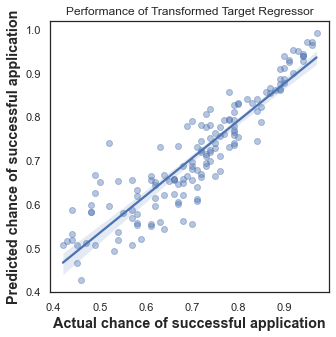

In [24]:
sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Y_test, predictions, scatter_kws={'alpha':0.4})
ax.set_xlabel('Actual chance of successful application', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted chance of successful application', fontsize='large', fontweight='bold')
ax.set(title='Performance of Transformed Target Regressor')
#ax.set_xlim(-15, 20)
#ax.set_ylim(-10, 5)
ax.figure.set_size_inches(5, 5)
plt.show
#plt.savefig("RandomForest_outliers_inlcuded.png")

Remarkably, with a dataset this small the performance of all these regression algorithms is essentially in the noise.

They appear to be so sensitive to the noise that each time you re-start the kernel you get a different answer about which has the highest predictive power. I am now going to scale the data to see if I can improve the performance of the model. 

Ok before we go any further I'm just going to highlight the power of sns pairplot to quickly look over the data: 

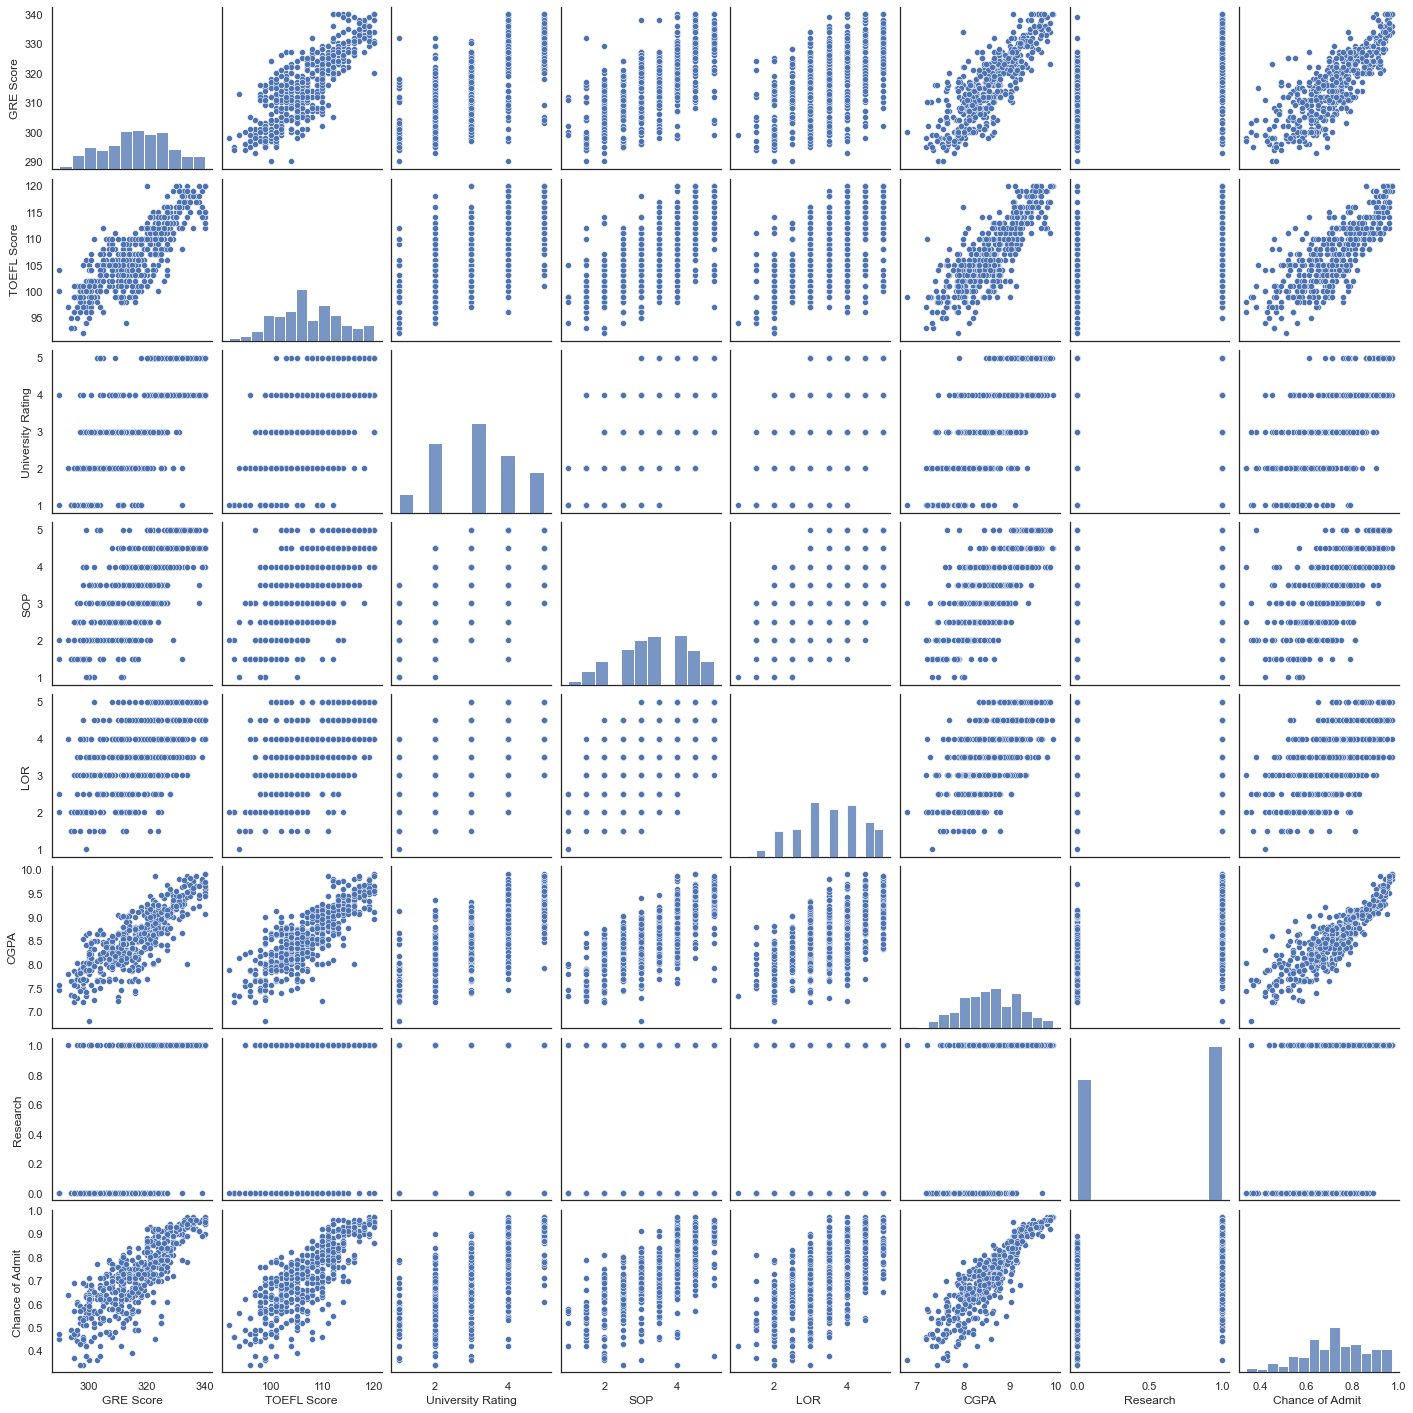

In [25]:
sns.pairplot(df)

Main reminder - to use the standard scaler which normalises to a mean of 0 and a standard deviation of 1 we need to ahve data that obeys a Gaussian (normal) distribution. 

MinMax scaler will transform all values from 0 to 1 and can be applied to data that is not normally distributed more effectively. We will likely try both. 

In [1]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_minmax = scaler.fit_transform(df)
column_names = df.columns
df_minmax = pd.DataFrame(df_minmax, columns = column_names)
df_minmax

NameError: name 'df' is not defined

In [38]:
#Check that scaling has been applied effectively
df_minmax.describe()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00
mean,0.53,0.54,0.53,0.59,0.62,0.57,0.56,0.61
std,0.23,0.22,0.29,0.25,0.23,0.19,0.50,0.22
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.36,0.39,0.25,0.38,0.50,0.43,0.00,0.46
50%,0.54,0.54,0.50,0.62,0.62,0.56,1.00,0.60
75%,0.70,0.71,0.75,0.75,0.75,0.72,1.00,0.76
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [41]:
#Will now create a similar standardised rather than normalized dataset
from sklearn.preprocessing import StandardScaler
scaler2 = StandardScaler()
df_stdscl = scaler2.fit_transform(df)
column_names = df.columns
df_stdscl = pd.DataFrame(df_stdscl, columns = column_names)
df_stdscl

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1.82,1.78,0.78,1.14,1.10,1.78,0.89,1.41
1,0.67,-0.03,0.78,0.63,1.10,0.49,0.89,0.27
2,-0.04,-0.53,-0.10,-0.38,0.02,-0.95,0.89,-0.01
3,0.49,0.46,-0.10,0.13,-1.06,0.15,0.89,0.56
4,-0.22,-0.69,-0.98,-1.39,-0.52,-0.61,-1.13,-0.51
...,...,...,...,...,...,...,...,...
495,1.38,0.13,1.65,1.14,0.56,0.73,0.89,1.05
496,1.82,1.61,1.65,1.64,1.64,2.14,0.89,1.69
497,1.20,2.11,1.65,1.14,1.64,1.63,0.89,1.48
498,-0.40,-0.69,0.78,0.63,1.64,-0.24,-1.13,0.06


In [42]:
#Check scaling has worked - mean should be 0 and std should be 1
df_stdscl.describe()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00
mean,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.35,-2.50,-1.85,-2.40,-2.69,-2.94,-1.13,-2.71
25%,-0.75,-0.69,-0.98,-0.88,-0.52,-0.74,-1.13,-0.65
50%,0.05,-0.03,-0.10,0.13,0.02,-0.03,0.89,-0.01
75%,0.76,0.79,0.78,0.63,0.56,0.77,0.89,0.70
max,2.09,2.11,1.65,1.64,1.64,2.22,0.89,1.76


We are now in a position to re-train and test our models using the two scaling approaches and monitor the performance to see which one we prefer. 

In [43]:
X1 = df_minmax[["GRE Score","TOEFL Score","University Rating","SOP","CGPA","Research", "LOR "]]
Y1 = df_minmax[["Chance of Admit "]]
X2 = df_stdscl[["GRE Score","TOEFL Score","University Rating","SOP","CGPA","Research", "LOR "]]
Y2 = df_stdscl[["Chance of Admit "]]

In [44]:
#For purposes of comparison (X and Y) are non normalised
#(X1 and Y1) are Minmax scaled - normalised
#(X2 and Y2) are Standard scaled - standardised
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1,Y1, test_size=0.3)
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X1,Y1, test_size=0.3)

In [46]:
#Run a lazypredict for each
from lazypredict.Supervised import LazyRegressor
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models1, predictions1 = reg.fit(X1_train, X1_test, Y1_train, Y1_test)
models2, predictions2 = reg.fit(X2_train, X2_test, Y2_train, Y2_test)

print(models1)
print(models2)

 33%|███▎      | 14/42 [00:00<00:00, 34.16it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 33%|███▎      | 14/42 [00:00<00:00, 33.56it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


100%|██████████| 42/42 [00:03<00:00, 13.55it/s]

                               R-Squared  RMSE  Time Taken
Model                                                     
HuberRegressor                      0.86  0.08        0.01
LinearSVR                           0.86  0.08        0.01
RidgeCV                             0.86  0.08        0.01
BayesianRidge                       0.86  0.08        0.00
Ridge                               0.86  0.08        0.00
ElasticNetCV                        0.86  0.08        0.03
LassoLarsIC                         0.86  0.08        0.01
SGDRegressor                        0.86  0.08        0.01
LassoCV                             0.86  0.08        0.03
LarsCV                              0.86  0.08        0.01
LassoLarsCV                         0.86  0.08        0.01
Lars                                0.86  0.08        0.01
TransformedTargetRegressor          0.86  0.08        0.00
LinearRegression                    0.86  0.08        0.00
OrthogonalMatchingPursuitCV         0.84  0.09        0.

There are a couple of observations at this point: 
    
   First of all the ML results have become much more stable now - the noise is not dominating the predictions
    
   Secondly the normalised data seems to perform slightly better than the standardised data
    
   Thirdly the overall performance of the models has improved very slightly to around 0.86 accuracy metric

In [47]:
#Now let's make a plot of the best performing model and see how it looks
from sklearn.linear_model import HuberRegressor
model = HuberRegressor()
model.fit(X1_train, Y1_train)
acc = model.score(X1_test, Y1_test)
acc

0.8627670416499389

In [50]:
#Create our predictions which we will use to graph our results:
predictions = model.predict(X1_test)

<function matplotlib.pyplot.show(close=None, block=None)>

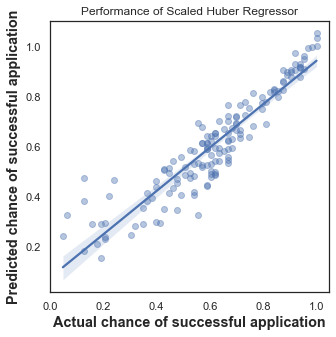

In [51]:
sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Y1_test, predictions, scatter_kws={'alpha':0.4})
ax.set_xlabel('Actual chance of successful application', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted chance of successful application', fontsize='large', fontweight='bold')
ax.set(title='Performance of Scaled Huber Regressor')
#ax.set_xlim(-15, 20)
#ax.set_ylim(-10, 5)
ax.figure.set_size_inches(5, 5)
plt.show
#plt.savefig("RandomForest_outliers_inlcuded.png")

This is where we'll leave this data analysis - with a model that can predict a students chances with an accuracy score of 0.86.

Be aware this is not the same as having an 86% chance of getting the answer correct because the 'chance of success' metric we were given was continuous not categorical. 

Eventually this has been pretty powerful but ultimately it is just a simple regression problem and we can probably find things that are more interesting to work on. 

In [ ]:
|